# Perform a simulation with ModularSimulator with propeller model

In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
#%config Completer.use_jedi = False

In [2]:
import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)
import numpy as np
import yaml

from vessel_manoeuvring_models.visualization.plot import track_plot, plot
from phd.visualization.plot_ship import track_plots
from vessel_manoeuvring_models.extended_kalman_vmm import ExtendedKalman, SystemMatrixes
from vmm_abkowitz_diminished import vmm as vmm
from wPCC_pipeline.pipelines.brix.nodes import initial_parameters, extract_added_masses
from wPCC_pipeline.pipelines.preprocess.nodes import load, add_thrust
from wPCC_pipeline.pipelines.filter_data_extended_kalman.nodes import guess_covariance_matrixes, initial_state, extended_kalman_filter, extended_kalman_smoother
from wPCC_pipeline.pipelines.motion_regression.nodes import predict_force, fit_motions, create_model_from_motion_regression
from wPCC_pipeline.pipelines.prediction.nodes import simulate_euler
from phd.pipelines.load_7m.nodes import fix_interpolated_angle
from sklearn.metrics import mean_squared_error
from vessel_manoeuvring_models.models.vmm import VMM, Simulator, ModelSimulator, get_coefficients
import sympy as sp
from functools import reduce
from operator import add
from vessel_manoeuvring_models.symbols import *
import vessel_manoeuvring_models.symbols as symbols
from vessel_manoeuvring_models.models.propeller import *
from vessel_manoeuvring_models.models.semiempirical_rudder import SemiempiricalRudderSystem
from IPython.display import display
from vessel_manoeuvring_models.prime_system import df_prime
from vessel_manoeuvring_models.substitute_dynamic_symbols import run, lambdify
from vessel_manoeuvring_models.models.modular_simulator import ModularVesselSimulator
from vessel_manoeuvring_models.models.subsystem import PrimeEquationSubSystem, EquationSubSystem
from vessel_manoeuvring_models.parameters import df_parameters
from phd.helpers import mean
from vessel_manoeuvring_models.angles import mean_angle
from vessel_manoeuvring_models.angles import smallest_signed_angle
from vessel_manoeuvring_models.models.diff_eq_to_matrix import DiffEqToMatrix
from vessel_manoeuvring_models.nonlinear_vmm_equations import X_eom, Y_eom, N_eom, fx_eq, fy_eq, mz_eq
import inspect
from sympy.printing import pretty
p = df_parameters["symbol"]

import logging
log = logging.getLogger(__name__)

import matplotlib.pyplot as plt
plt.style.use('bmh')

In [3]:
%reload_kedro
ship='wPCC'
time_series = catalog.load(f"{ship}.time_series")
time_series_smooth = catalog.load(f"{ship}.time_series_preprocessed.ek_smooth")
ship_data = catalog.load(f"{ship}.ship_data")
exclude_parameters = catalog.load(f"params:{ship}.exclude_parameters")
time_series_meta_data = catalog.load(f"{ship}.time_series_meta_data")
time_series_meta_data.index = time_series_meta_data.index.astype(str)
time_series_meta_data.rename(columns={'test_type':'test type'}, inplace=True)
model_loader = catalog.load(f"{ship}.models")

[06/08/23 08:38:44] INFO     Resolved project path as: /home/maa/dev/PHD.                           ]8;id=296451;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=455943;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#134\134]8;;\
                             To set a different path, run '%reload_kedro <project_root>'                           

[06/08/23 08:38:50] INFO     Kedro project phd                                                      ]8;id=434477;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=864884;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#103\103]8;;\

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=693091;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=724555;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#104\104]8;;\
                             'pipelines'                                                                           

                    INFO     Registered line magic 'run_viz'                                        ]8;id=465191;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=216966;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#110\110]8;;\

                    INFO     Loading data from 'wPCC.time_series' (PartitionedDataSet)...       ]8;id=788629;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=955522;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'wPCC.time_series_preprocessed.ek_smooth'        ]8;id=307340;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=929078;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\
                             (PartitionedDataSet)...                                                               

                    INFO     Loading data from 'wPCC.ship_data' (YAMLDataSet)...                ]8;id=581823;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=261642;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'params:wPCC.exclude_parameters'                 ]8;id=471314;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=583996;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\
                             (MemoryDataSet)...                                                                    

                    INFO     Loading data from 'wPCC.time_series_meta_data' (CSVDataSet)...     ]8;id=733052;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=588779;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'wPCC.models' (PartitionedDataSet)...            ]8;id=15805;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=984283;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

In [4]:
fx_eq = fx_eq.subs(X_D,X_D_)
fy_eq = fy_eq.subs(Y_D,Y_D_)
mz_eq = mz_eq.subs(N_D,N_D_)

eq_X_force = fx_eq.subs(X_D_, X_H + X_P)
eq_Y_force = fy_eq.subs(Y_D_, Y_H)
eq_N_force = mz_eq.subs(N_D_, N_H)

X_eq = X_eom.subs(X_force,eq_X_force.rhs)
Y_eq = Y_eom.subs(Y_force,eq_Y_force.rhs)
N_eq = N_eom.subs(N_force,eq_N_force.rhs)
subs = [
    (p.Xvdot, 0),
    (p.Xrdot, 0),
    (p.Yudot, 0),
    # (p.Yrdot,0),  # this is probably not true
    (p.Nudot, 0),
    # (p.Nvdot,0),# this is probably not true
]
X_eq=X_eq.subs(subs)
Y_eq=Y_eq.subs(subs)
N_eq=N_eq.subs(subs)

display(X_eq)
display(Y_eq)
display(N_eq)

Eq(m*(\dot{u} - r**2*x_G - r*v), X_H + X_P + X_{\dot{u}}*\dot{u})

Eq(m*(\dot{r}*x_G + \dot{v} + r*u), Y_H + Y_{\dot{r}}*\dot{r} + Y_{\dot{v}}*\dot{v})

Eq(I_z*\dot{r} + m*x_G*(\dot{v} + r*u), N_H + N_{\dot{r}}*\dot{r} + N_{\dot{v}}*\dot{v})

In [5]:
model_old= model_loader['wpcc.updated.vmm_martins_simple.joined.model']()

In [6]:
parameters = dict(model_old.parameters)
params = {'C0_w_p0': 0.10378571428571445,
 'C1_w_p0': 0.24690520231438584,
 'k_0': 0.576581716472807,
 'k_1': -0.3683675998138215,
 'k_2': -0.07542975438913463}
parameters.update(params)
g_=9.81
parameters['g'] = g_ 

In [7]:
model = ModularVesselSimulator(X_eq=X_eq, Y_eq=Y_eq, N_eq=N_eq, 
                               ship_parameters=ship_data, 
                               parameters=parameters, 
                               control_keys=['delta','rev'], do_create_jacobian=False)

## Add thrust prediction model

In [9]:
C0_w_p0,C1_w_p0,F_n = sp.symbols("C0_w_p0, C1_w_p0,F_n")
eq_w_p0 = sp.Eq(w_p0, C0_w_p0 + C1_w_p0*F_n)
eq_w_p0

Eq(w_p0, C0_w_p0 + C1_w_p0*F_n)

In [10]:
eq_F_n = sp.Eq(F_n,U/sp.sqrt(L*g))
eq_F_n

Eq(F_n, U/sqrt(L*g))

In [11]:
eq_w_p0 = eq_w_p0.subs(F_n, eq_F_n.rhs)
eq_w_p0

Eq(w_p0, C0_w_p0 + C1_w_p0*U/sqrt(L*g))

Assuming that $w_{p0}$ is a good model:

In [12]:
eq_w_p = eq_w_p0.subs(w_p0,w_p)
eq_w_p

Eq(w_p, C0_w_p0 + C1_w_p0*U/sqrt(L*g))

In [13]:
eqs = [eq_T,eq_K_T, eq_J, eq_w_p]
solution = sp.solve(eqs, thrust_propeller, K_T, J, w_p, dict=True)
eq = sp.Eq(thrust,n_prop*solution[0][thrust_propeller])
eq

Eq(thrust, D**2*n_prop*rho*(C0_w_p0**2*L*g*k_2*u**2 + 2*C0_w_p0*C1_w_p0*U*k_2*u**2*sqrt(L*g) - C0_w_p0*D*L*g*k_1*rev*u - 2*C0_w_p0*L*g*k_2*u**2 + C1_w_p0**2*U**2*k_2*u**2 - C1_w_p0*D*U*k_1*rev*u*sqrt(L*g) - 2*C1_w_p0*U*k_2*u**2*sqrt(L*g) + D**2*L*g*k_0*rev**2 + D*L*g*k_1*rev*u + L*g*k_2*u**2)/(L*g))

In [14]:
eq_X_P = sp.Eq(X_P, p.Xthrust*thrust)

In [15]:
propeller_equations = [eq, eq_X_P]
propellers = EquationSubSystem(ship=model, equations=propeller_equations, create_jacobians=False)
model.subsystems['propellers'] = propellers

## Add hull

In [16]:
eq_X_H = model_old.X_qs_eq.subs([
(X_D, X_H,),
(thrust,0),
])

eq_Y_H = model_old.Y_qs_eq.subs([
(Y_D, Y_H,),
])

eq_N_H = model_old.N_qs_eq.subs([
(N_D, N_H,),
])

display(eq_X_H)
display(eq_Y_H)
display(eq_N_H)


Eq(X_H, X_{deltadelta}*delta**2 + X_{rr}*r**2 + X_{uu}*u**2 + X_{u}*u + X_{vr}*r*v)

Eq(Y_H, Y_{delta}*delta + Y_{r}*r + Y_{thrustdelta}*delta*thrust + Y_{thrust}*thrust + Y_{ur}*r*u + Y_{u}*u + Y_{vvdelta}*delta*v**2 + Y_{v}*v)

Eq(N_H, N_{delta}*delta + N_{r}*r + N_{thrustdelta}*delta*thrust + N_{thrust}*thrust + N_{ur}*r*u + N_{u}*u + N_{vvdelta}*delta*v**2 + N_{v}*v)

In [17]:
equations_hull = [eq_X_H, eq_Y_H, eq_N_H]
hull = PrimeEquationSubSystem(ship=model, equations=equations_hull, create_jacobians=False)
model.subsystems['hull'] = hull

## Resimulate

In [18]:
data = time_series_smooth['wpcc.updated.22773.ek_smooth']()
#data = time_series_smooth['wpcc.updated.22774.ek_smooth']()
data['V'] = data['U'] = np.sqrt(data['u']**2 + data['v']**2)
data['rev'] = data[['Prop/SB/Rpm', 'Prop/PS/Rpm']].mean(axis=1)

In [19]:
data_ = data.drop(columns=['thrust'])
result = model.simulate(data_)

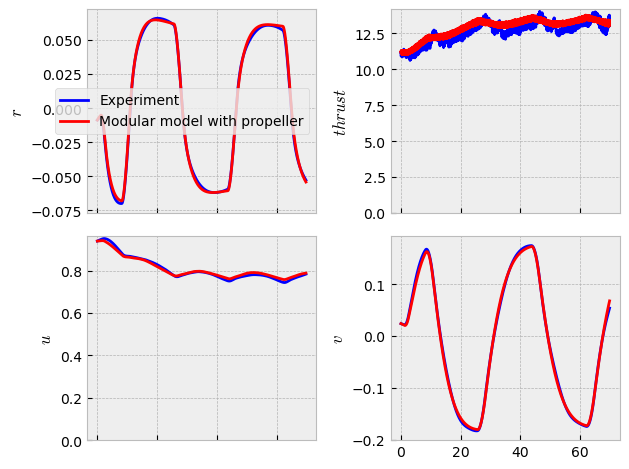

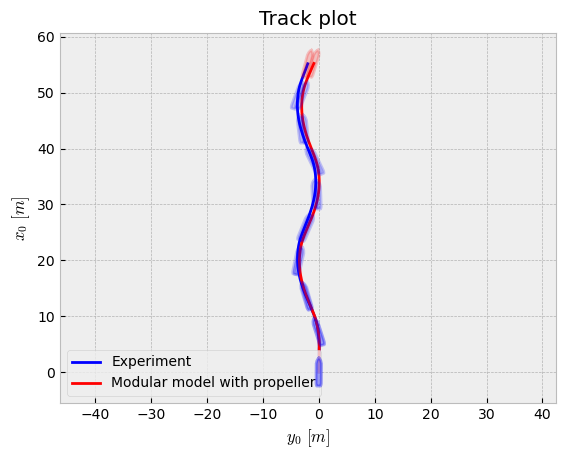

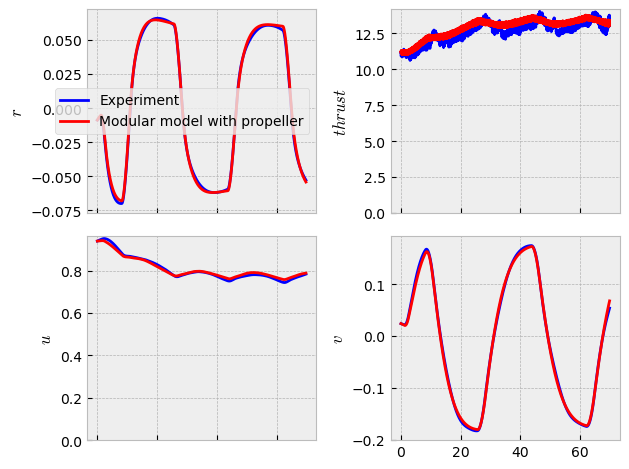

In [20]:
dataframes = {
              'Experiment':data,
              'Modular model with propeller':result,
             }
ax = track_plots(dataframes=dataframes, lpp=ship_data['L'], beam=ship_data['B'], N=10)
plot(dataframes, keys=['u','v','r','thrust'])